# Análisis Exploratorio de Datos (EDA)
## Detección de Anomalías en Ataques de Consul Poisoning

**Fecha:** Enero 2026

---

### Contenido

1. Introducción
2. Carga de Datos
3. Análisis de la Variable Objetivo
4. Calidad de Datos (Nulos y Tipos)
5. Estadísticas Descriptivas
6. Análisis de Correlaciones
7. Análisis de Distribuciones
8. Reducción de Dimensionalidad (PCA, UMAP, t-SNE)
9. Análisis de 
10. Conclusiones

## 1. Introducción
El presente análisis exploratorio se centra en el estudio de un conjunto de datos diseñado para la detección de comportamientos anómalos en un entorno de seguridad, con el objetivo de evaluar si la información disponible permite diferenciar de forma efectiva entre actividad legítima y potencialmente maliciosa. Dado que el enfoque adoptado se basa en técnicas de aprendizaje no supervisado, resulta fundamental caracterizar en profundidad el comportamiento normal del sistema y analizar cómo se manifiestan las desviaciones asociadas a escenarios de ataque. En este contexto, el EDA se orienta a identificar patrones temporales, distribuciones y relaciones entre variables que puedan ser indicativas de un ataque de Consul poisoning, así como a detectar posibles limitaciones del dataset que puedan afectar al posterior proceso de modelado.

## Descripción del problema
La arquitectura analizada está basada en microservicios desplegados en la nube (AWS) y utiliza Consul como mecanismo de service registry y service discovery. Cada microservicio, al iniciarse o reiniciarse, envía una petición de registro a Consul para anunciar su disponibilidad. Posteriormente, los microservicios consultan a Consul para resolver la ubicación de otros servicios dentro del sistema.

El ataque objeto de estudio es el denominado Consul Poisoning, un ataque dirigido al plano de control de la arquitectura. En este escenario, un atacante que ya ha conseguido acceso a la red interna es capaz de enviar peticiones maliciosas de registro a Consul, suplantando la identidad de servicios legítimos como auth u order. Como consecuencia, Consul puede registrar instancias maliciosas como si fueran servicios válidos, provocando que el tráfico legítimo sea redirigido hacia el atacante.

Este tipo de ataque resulta especialmente crítico, ya que no requiere comprometer directamente los microservicios, sino que explota la confianza del sistema en el mecanismo de descubrimiento de servicios. Además, el comportamiento malicioso puede mimetizarse parcialmente con tráfico legítimo, dificultando su detección mediante reglas estáticas o mecanismos tradicionales de seguridad perimetral.

Ante este contexto, se plantea el uso de técnicas de detección de anomalías mediante aprendizaje no supervisado, con el objetivo de identificar desviaciones en el patrón normal de registros de servicios que puedan ser indicativas de un ataque de Consul poisoning.

## Descripción del conjunto de datos
El conjunto de datos utilizado en este estudio ha sido generado a partir de capturas de tráfico real hacia Consul en un entorno de microservicios controlado. Dichas capturas incluyen tanto comportamiento legítimo como tráfico malicioso introducido de forma deliberada para simular ataques de Consul poisoning.

### Dataset original
El dataset original contiene registros individuales de peticiones de registro de servicios a Consul, incluyendo eventos generados por:

- Microservicios legítimos al iniciarse o reiniciarse.

- Servicios maliciosos que intentan suplantar identidades legítimas mediante registros falsos.

Este dataset representa el comportamiento a bajo nivel del sistema y sirve como base para la construcción de un conjunto de datos más adecuado para detección de anomalías.

### Dataset con sliding windows
A partir del dataset original se ha construido un segundo conjunto de datos mediante el uso de ventanas deslizantes temporales (sliding windows). Cada instancia del dataset agregado representa el comportamiento del sistema durante un intervalo de tiempo determinado, agrupando las peticiones de registro en función de la dirección IP de origen y del tiempo. Sobre estas agrupaciones se han calculado características derivadas que capturan aspectos como la frecuencia, diversidad y repetición de los registros de servicios.

Este enfoque parte de la premisa de que una petición individual de registro a Consul no resulta, por sí sola, indicativa de un comportamiento malicioso, ya que la operación de registro de servicios forma parte del funcionamiento normal del sistema. En consecuencia, el análisis no se centra en el estudio de peticiones aisladas a nivel micro, sino en la dinámica agregada del tráfico generada por una misma IP a lo largo del tiempo.

El dataset ha sido estructurado siguiendo un enfoque basado en flujos, similar al utilizado en tecnologías como NetFlow, donde cada instancia representa el comportamiento agregado de un origen durante una ventana temporal concreta. Este tipo de representación permite capturar patrones anómalos que solo emergen cuando se analiza el tráfico a nivel macro, y no como eventos individuales.

El dataset basado en ventanas deslizantes es el que se utiliza tanto para el análisis exploratorio como para el entrenamiento del modelo de clustering no supervisado, ya que proporciona una representación más robusta, contextualizada y adecuada para la detección de anomalías que el análisis de peticiones individuales.

## 2. Configuración e Importación de Librerías

In [4]:
# ============================================================================
# CONFIGURACIÓN DEL ENTORNO
# ============================================================================

# Bibliotecas fundamentales
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Estadística
from scipy import stats
from scipy.stats import mannwhitneyu, ks_2samp, chi2_contingency

# Machine Learning
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import mutual_info_classif
import umap
import hdbscan

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Colores corporativos para el análisis
COLORS = {
    'normal': '#2ecc71',      # Verde
    'attack': '#e74c3c',      # Rojo
    'primary': '#3498db',     # Azul
    'secondary': '#9b59b6',   # Púrpura
    'warning': '#f39c12',     # Naranja
    'neutral': '#95a5a6'      # Gris
}

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Entorno configurado correctamente")
print(f"  - NumPy: {np.__version__}")
print(f"  - Pandas: {pd.__version__}")

✓ Entorno configurado correctamente
  - NumPy: 2.3.5
  - Pandas: 2.3.3


<a id="carga-datos"></a>
## 3. Carga y Exploración Inicial

### 3.1 Lectura del Dataset

In [5]:
# Carga del dataset
df = pd.read_csv('../data/processed/windowed_dataset.csv')

# Vista previa
print(f"{'='*60}")
print(f"RESUMEN DEL DATASET")
print(f"{'='*60}")
print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\n{'='*60}")
print("PRIMERAS FILAS DEL DATASET")
print(f"{'='*60}")
df.head()

RESUMEN DEL DATASET
Dimensiones: 24,005 filas × 94 columnas
Memoria: 18.57 MB

PRIMERAS FILAS DEL DATASET


,id.orig_h,window_start,window_end,window_duration,n_connections,id.orig_p_mean,id.orig_p_std,id.orig_p_max,id.resp_p_mean,id.resp_p_std,id.resp_p_max,orig_bytes_mean,orig_bytes_std,orig_bytes_max,resp_bytes_mean,resp_bytes_std,resp_bytes_max,bytes_ratio_mean,bytes_ratio_std,bytes_ratio_max,duration_mean,duration_std,duration_max,duration_zscore_mean,duration_zscore_std,duration_zscore_max,conn_state_encoded_mean,conn_state_encoded_std,conn_state_encoded_max,conn_interval_mean,conn_interval_std,conn_interval_max,time_since_last_conn_mean,time_since_last_conn_std,time_since_last_conn_max,conn_count_10s_mean,conn_count_10s_std,conn_count_10s_max,conn_count_60s_mean,conn_count_60s_std,conn_count_60s_max,conn_count_300s_mean,conn_count_300s_std,conn_count_300s_max,interval_stddev_mean,interval_stddev_std,interval_stddev_max,burst_score_mean,burst_score_std,burst_score_max,total_conn_from_ip_mean,total_conn_from_ip_std,total_conn_from_ip_max,hour_of_day_mean,hour_of_day_std,hour_of_day_max,ja3_frequency_mean,ja3_frequency_std,ja3_frequency_max,ja3_is_known_mean,ja3_is_known_std,ja3_is_known_max,ja3_behavior_score_mean,ja3_behavior_score_std,ja3_behavior_score_max,unique_ja3_from_ip_mean,unique_ja3_from_ip_std,unique_ja3_from_ip_max,is_known_ip_mean,is_known_ip_std,is_known_ip_max,ip_first_seen_hours_ago_mean,ip_first_seen_hours_ago_std,ip_first_seen_hours_ago_max,recon_pattern_score_mean,recon_pattern_score_std,recon_pattern_score_max,recent_activity_score_mean,recent_activity_score_std,recent_activity_score_max,recent_docker_event_mean,recent_docker_event_std,recent_docker_event_max,time_since_container_start_mean,time_since_container_start_std,time_since_container_start_max,id.resp_h_nunique,ja3_nunique,attack_phase_nunique,is_attack_count,is_attack_ratio,is_attack_any,is_attack_majority,is_attack
0,172.18.0.1,1767522399.4346,1767522414.4346,15.0000,7,47966.0000,14.6515,47994,8501.0000,0.0000,8501,839.2857,86.7654,1034.0000,3414.0000,2070.4809,7605.0000,0.2310,0.0930,0.3642,0.0118,0.0073,0.0239,-0.1121,0.5727,0.8320,0.0000,0.0000,0,0.2919,0.2137,0.5334,0.3405,0.1869,0.5334,4.0000,2.1602,7,4.0000,2.1602,7,4.0000,2.1602,7,159.3868,0.0000,159.3868,0.8571,0.3780,1.0000,4.0000,2.1602,7,11.0000,0.0000,11,441.0000,0.0000,441,0.0000,0.0000,0,0.5000,0.0000,0.5000,1.0000,0.0000,1,0.0000,0.0000,0,0.0003,0.0002,0.0006,0.8429,0.3047,1.0000,0.5714,0.3086,1.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,1,1,2,7,1.0000,1,1,1
1,172.18.0.1,1767523079.4346,1767523094.4346,15.0000,2,53218.0000,11.3137,53226,8501.0000,0.0000,8501,800.0000,2.8284,802.0000,5499.5000,4575.6880,8735.0000,0.1724,0.1248,0.2606,0.0090,0.0033,0.0114,-0.3297,0.2590,-0.1465,0.0000,0.0000,0,346.4113,489.4390,692.4969,346.4113,489.4390,692.4969,1.5000,0.7071,2,1.5000,0.7071,2,1.5000,0.7071,2,159.3868,0.0000,159.3868,0.5000,0.7071,1.0000,8.5000,0.7071,9,11.0000,0.0000,11,441.0000,0.0000,441,0.0000,0.0000,0,0.5000,0.0000,0.5000,1.0000,0.0000,1,0.0000,0.0000,0,0.1337,0.0001,0.1338,0.3500,0.4950,0.7000,0.2143,0.1010,0.2857,0.0000,0.0000,0,0.0000,0.0000,0.0000,1,1,1,2,1.0000,1,1,1
2,172.18.0.1,1767523084.4346,1767523099.4346,15.0000,7,50166.8571,5235.4258,53248,8501.0000,0.0000,8501,837.1429,85.4077,1029.0000,6332.2857,4362.6509,12578.0000,0.1793,0.1289,0.3631,0.0107,0.0056,0.0219,-0.1964,0.4387,0.6789,0.0000,0.0000,0,99.2196,261.6108,692.4969,99.2196,261.6108,692.4969,4.0000,2.1602,7,4.0000,2.1602,7,4.0000,2.1602,7,159.3868,0.0000,159.3868,0.8571,0.3780,1.0000,11.0000,2.1602,14,11.0000,0.0000,11,441.0000,0.0000,441,0.0000,0.0000,0,0.5000,0.0000,0.5000,1.0000,0.0000,1,0.0000,0.0000,0,0.1340,0.0002,0.1342,0.8143,0.3761,1.0000,0.5714,0.3086,1.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,1,1,3,7,1.0000,1,1,1
3,172.18.0.1,1767523089.4346,1767523104.4346,15.0000,7,50166.8571,5235.4258,53248,8501.0000,0.0000,8501,837.1429,85.4077,1029.0000,6332.2857,4362.6509,12578.0000,0.1793,0.1289,0.3631,0.0107,0.0056,0.0219,-0.1964,0.4387,0.6789,0.0000,0.0000,0,99.2196,261.6108,692.4969,99.2196,261.6108,692.49

### 3.2 Análisis de la Variable Objetivo

Antes de proceder con el EDA, es fundamental entender la distribución de la variable objetivo (`is_attack`) para contextualizar todos los análisis posteriores. Al ser un problema de clustering no hay una variable objetivo como tal pero para entender mejor las visualizaciones si que es necesario tenerlo. Luego más adelante se eliminará.

### 3.3 Dimensionalidad y Estructura de los Datos

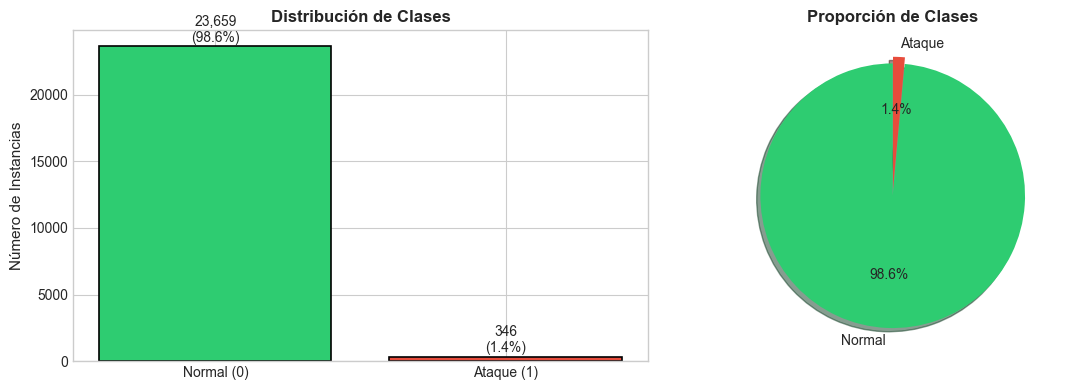


📊 Ratio de desbalance (Normal/Ataque): 68.38:1


In [7]:
# Análisis de la variable objetivo
target_col = 'is_attack' if 'is_attack' in df.columns else 'is_attack_any'
target_dist = df[target_col].value_counts()
target_pct = df[target_col].value_counts(normalize=True) * 100

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de barras
bars = axes[0].bar(['Normal (0)', 'Ataque (1)'], target_dist.values, 
                   color=[COLORS['normal'], COLORS['attack']], edgecolor='black', linewidth=1.2)
axes[0].set_ylabel('Número de Instancias', fontsize=11)
axes[0].set_title('Distribución de Clases', fontsize=12, fontweight='bold')
for bar, val, pct in zip(bars, target_dist.values, target_pct.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                 f'{val:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)

# Gráfico de pastel
axes[1].pie(target_dist.values, labels=['Normal', 'Ataque'], autopct='%1.1f%%',
            colors=[COLORS['normal'], COLORS['attack']], explode=(0, 0.05),
            shadow=True, startangle=90)
axes[1].set_title('Proporción de Clases', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Ratio de desbalance
imbalance_ratio = target_dist[0] / target_dist[1] if target_dist[1] > 0 else float('inf')
print(f"\n📊 Ratio de desbalance (Normal/Ataque): {imbalance_ratio:.2f}:1")

### Conclusión: Distribución de la Variable Objetivo

**Resultados obtenidos:**
- **23,659 instancias normales (98.6%)** vs **346 ataques (1.4%)**
- Ratio de desbalance: **68:1** (por cada ataque hay 68 ventanas normales)

**¿Qué significa esto?**
- El dataset está **muy desbalanceado**, lo cual es típico en detección de intrusiones (los ataques son eventos raros)
- Solo el 1.4% del tráfico corresponde a ataques de Consul Poisoning
- Este desbalance es BUENO para detección de anomalías: asumimos que lo "normal" es la mayoría

In [9]:
# Análisis detallado de la estructura
print(f"{'='*60}")
print("ESTRUCTURA DEL DATASET")
print(f"{'='*60}")
print(f"\nDimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")

# Clasificación de columnas por tipo
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nTipos de Variables:")
print(f"   • Numéricas: {len(numeric_cols)}")
print(f"   • Categóricas/Texto: {len(categorical_cols)}")

# Identificar columnas especiales
meta_cols = ['id.orig_h', 'window_start', 'window_end', 'window_duration']
target_cols = [c for c in df.columns if 'attack' in c.lower()]
feature_cols = [c for c in df.columns if c not in meta_cols + target_cols]

print(f"\nClasificación de Columnas:")
print(f"   • Metadatos/Identificadores: {len([c for c in meta_cols if c in df.columns])}")
print(f"   • Variables objetivo (attack): {len(target_cols)}")
print(f"   • Features para modelado: {len(feature_cols)}")

ESTRUCTURA DEL DATASET

Dimensiones: 24,005 filas × 94 columnas

Tipos de Variables:
   • Numéricas: 93
   • Categóricas/Texto: 1

Clasificación de Columnas:
   • Metadatos/Identificadores: 4
   • Variables objetivo (attack): 6
   • Features para modelado: 84


<a id="calidad-datos"></a>
## 4. Análisis de Calidad de Datos

### 4.1 Tipos de Datos por Columna

In [10]:
# Resumen de tipos de datos
dtype_summary = pd.DataFrame({
    'Tipo': df.dtypes,
    'Valores Únicos': df.nunique(),
    'Ejemplo': df.iloc[0]
})
print("TIPOS DE DATOS POR COLUMNA")
print("="*60)
print(dtype_summary.to_string())

TIPOS DE DATOS POR COLUMNA
                                    Tipo  Valores Únicos         Ejemplo
id.orig_h                         object               9      172.18.0.1
window_start                     float64           24005 1767522399.4346
window_end                       float64           24005 1767522414.4346
window_duration                  float64               1         15.0000
n_connections                      int64              11               7
id.orig_p_mean                   float64            8178      47966.0000
id.orig_p_std                    float64            1080         14.6515
id.orig_p_max                      int64            7439           47994
id.resp_p_mean                   float64               1       8501.0000
id.resp_p_std                    float64               1          0.0000
id.resp_p_max                      int64               1            8501
orig_bytes_mean                  float64            1183        839.2857
orig_bytes_std          

### Conclusión: Estructura del Dataset

**Resultados obtenidos:**
- **24,005 filas** (cada fila = comportamiento de una IP en una ventana de tiempo)
- **94 columnas** en total:
  - 93 numéricas + 1 categórica (IP origen)
  - 4 columnas de metadatos (IP, timestamps)
  - 6 columnas objetivo (diferentes definiciones de "ataque")
  - **84 features** disponibles para modelado

**¿Qué representan las features?**
- Variables agregadas dentro de cada ventana temporal: medias, máximos, desviaciones estándar
- Métricas de comportamiento: `conn_count_10s` (conexiones en 10s), `burst_score` (ráfagas), `recon_pattern_score` (patrones de reconocimiento)
- La mayoría son numéricas → ideal para algoritmos de clustering

### 4.2 Preparación del Dataset para Análisis

Se excluyen las columnas de metadatos, identificadores y variables objetivo para el análisis exploratorio, ya que no deben formar parte del modelo no supervisado.

In [11]:
# Columnas a excluir del análisis
excluded_cols = [
    'id.orig_h',           # Identificador IP
    'window_start',        # Timestamp
    'window_end',          # Timestamp
    'window_duration',     # Derivada de timestamps
    'is_attack',           # Variable objetivo
    'is_attack_any',       # Variable objetivo
    'is_attack_majority',  # Variable objetivo
    'is_attack_count',     # Variable objetivo
    'is_attack_ratio',     # Variable objetivo
    'attack_phase_nunique' # Variable objetivo
]

# Guardar labels para análisis posterior
labels = df['is_attack'].values if 'is_attack' in df.columns else df['is_attack_any'].values

# Crear dataset para EDA
df_eda = df.drop(columns=[c for c in excluded_cols if c in df.columns])

print(f"✓ Dataset preparado para EDA: {df_eda.shape[0]:,} filas × {df_eda.shape[1]} columnas")
print(f"✓ Labels guardados: {len(labels):,} ({(labels==1).sum():,} ataques, {(labels==0).sum():,} normales)")

✓ Dataset preparado para EDA: 24,005 filas × 84 columnas
✓ Labels guardados: 24,005 (346 ataques, 23,659 normales)


### 4.3 Análisis de Valores Nulos

In [13]:
# Análisis detallado de valores nulos
null_analysis = pd.DataFrame({
    'Nulos': df_eda.isnull().sum(),
    'Porcentaje': (df_eda.isnull().sum() / len(df_eda) * 100).round(2),
    'Tipo': df_eda.dtypes
})
null_analysis = null_analysis[null_analysis['Nulos'] > 0].sort_values('Nulos', ascending=False)

if len(null_analysis) > 0:
    
    print(f"\nResumen de Valores Nulos:")
    print(f"   • Variables con nulos: {len(null_analysis)}")
    print(f"   • Total de valores nulos: {df_eda.isnull().sum().sum():,}")
    print(f"\nVariables con >5% nulos:")
    high_null = null_analysis[null_analysis['Porcentaje'] > 5]
    if len(high_null) > 0:
        print(high_null[['Nulos', 'Porcentaje']].to_string())
    else:
        print("   Ninguna")
else:
    print("✓ No hay valores nulos en el dataset")


Resumen de Valores Nulos:
   • Variables con nulos: 29
   • Total de valores nulos: 592,287

Variables con >5% nulos:
                                Nulos  Porcentaje
time_since_last_conn_std        21937     91.3900
id.resp_p_std                   21936     91.3800
orig_bytes_std                  21936     91.3800
resp_bytes_std                  21936     91.3800
id.orig_p_std                   21936     91.3800
bytes_ratio_std                 21936     91.3800
duration_std                    21936     91.3800
conn_state_encoded_std          21936     91.3800
duration_zscore_std             21936     91.3800
conn_interval_std               21936     91.3800
conn_count_10s_std              21936     91.3800
conn_count_300s_std             21936     91.3800
conn_count_60s_std              21936     91.3800
ja3_behavior_score_std          21936     91.3800
unique_ja3_from_ip_std          21936     91.3800
interval_stddev_std             21936     91.3800
burst_score_std                

### Conclusión: Análisis de Valores Nulos

**Resultados obtenidos:**
- **29 variables con nulos** de 84 features
- **592,287 valores nulos** en total
- **27 variables con más del 91% de nulos** (casi todas las variables `_std`)

**¿Por qué ocurre esto?**
- Las variables con sufijo `_std` (desviación estándar) requieren al menos 2 valores para calcularse
- El **91.38% de ventanas tienen solo 1 conexión**, por lo que no se puede calcular desviación estándar
- Esto es información valiosa: la mayoría del tráfico tiene pocas conexiones por ventana

**Estrategia de tratamiento:**
- Se imputaran los nulos referentes a los estandar con el valor 0
- Los nulos NO indican errores de datos, sino ventanas con una sola conexión

<a id="análisis-univariante"></a>
## 5. Análisis Univariante

### 5.1 Estadísticas Descriptivas

In [16]:
# Estadísticas descriptivas extendidas
desc_stats = df_eda.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T
desc_stats['range'] = desc_stats['max'] - desc_stats['min']
desc_stats['iqr'] = desc_stats['75%'] - desc_stats['25%']
desc_stats['cv'] = (desc_stats['std'] / desc_stats['mean'].replace(0, np.nan)).abs()  # Coeficiente de variación

print("="*80)
print("ESTADÍSTICAS DESCRIPTIVAS EXTENDIDAS")
print("="*80)
print(f"\nVariables numéricas analizadas: {len(desc_stats)}")

# Mostrar resumen en formato tabla
print("\n" + desc_stats[['count', 'mean', 'std', 'min', '50%', 'max', 'range', 'cv']].round(3).to_string())

# Resumen de hallazgos
print("\n" + "="*80)
print("RESUMEN DE HALLAZGOS")
print("="*80)
print(f"\nVariables con alta variabilidad (CV > 1): {(desc_stats['cv'] > 1).sum()}")
print(f"Variables con valores negativos: {(desc_stats['min'] < 0).sum()}")
print(f"Variables con rango muy amplio (range > 1000): {(desc_stats['range'] > 1000).sum()}")

# Mostrar las 5 variables con mayor coeficiente de variación
print("\nTop 5 variables con mayor variabilidad relativa (CV):")
top_cv = desc_stats['cv'].dropna().nlargest(5)
for var, cv in top_cv.items():
    print(f"   • {var}: CV = {cv:.2f}")

ESTADÍSTICAS DESCRIPTIVAS EXTENDIDAS

Variables numéricas analizadas: 84

                                     count       mean       std        min        50%        max      range      cv
n_connections                   24005.0000     1.1580    0.7890     1.0000     1.0000    14.0000    13.0000  0.6820
id.orig_p_mean                  24005.0000 49005.0290 9280.8160 32771.0000 48945.0000 65532.0000 32761.0000  0.1890
id.orig_p_std                    2069.0000  6096.2050 5486.3890     1.4140  5156.9300 22078.7020 22077.2880  0.9000
id.orig_p_max                   24005.0000 49388.4780 9435.8290 32771.0000 49484.0000 65532.0000 32761.0000  0.1910
id.resp_p_mean                  24005.0000  8501.0000    0.0000  8501.0000  8501.0000  8501.0000     0.0000  0.0000
id.resp_p_std                    2069.0000     0.0000    0.0000     0.0000     0.0000     0.0000     0.0000     NaN
id.resp_p_max                   24005.0000  8501.0000    0.0000  8501.0000  8501.0000  8501.0000     0.0000  0.000

### Conclusión: Estadísticas Descriptivas

**Hallazgos principales:**
- Las variables muestran diferentes escalas y distribuciones, lo que justifica el uso de escalado robusto
- El coeficiente de variación (CV) nos indica qué variables son más "informativas" - aquellas con alta variabilidad pueden capturar mejor las diferencias entre comportamientos
- Variables con CV muy bajo podrían ser candidatas a eliminación por baja varianza

**¿Qué nos dice esto sobre los datos?**
- La diversidad en rangos indica que el RobustScaler será más apropiado que StandardScaler
- Las variables con rangos muy amplios probablemente contienen outliers (esperado en datos de red)
- Las diferencias en magnitudes refuerzan la necesidad de normalización antes del clustering

### 5.2 Identificación de Variables Constantes y de Baja Varianza

In [19]:
# Funciones auxiliares para clasificación de variables
def classify_variable(series):
    """Clasifica una variable como binaria, constante o continua."""
    unique_vals = series.dropna().unique()
    n_unique = len(unique_vals)
    
    if n_unique <= 1:
        return "constant"
    elif n_unique == 2 and set(unique_vals).issubset({0, 1, 0.0, 1.0}):
        return "binary"
    elif n_unique <= 10:
        return "categorical"
    else:
        return "continuous"

# Clasificar todas las variables
var_classification = {col: classify_variable(df_eda[col]) for col in df_eda.columns}
var_df = pd.DataFrame.from_dict(var_classification, orient='index', columns=['Tipo'])

# Identificar variables constantes
constant_vars = [col for col, tipo in var_classification.items() if tipo == 'constant']
low_variance_vars = []

for col in df_eda.select_dtypes(include='number').columns:
    if col not in constant_vars:
        # Calcular ratio de valor más frecuente
        mode_ratio = df_eda[col].value_counts(normalize=True).iloc[0]
        if mode_ratio > 0.99:  # Más del 99% es el mismo valor
            low_variance_vars.append((col, mode_ratio))

print("CLASIFICACIÓN DE VARIABLES")
print("="*60)
print(f"\nResumen por tipo:")
for tipo in ['continuous', 'binary', 'categorical', 'constant']:
    count = sum(1 for t in var_classification.values() if t == tipo)
    print(f"   • {tipo.capitalize()}: {count}")

if constant_vars:
    print(f"\nVariables CONSTANTES (a eliminar): {len(constant_vars)}")
    for var in constant_vars:
        print(f"   • {var}")

if low_variance_vars:
    print(f"\nVariables con BAJA VARIANZA (>99% mismo valor): {len(low_variance_vars)}")
    for var, ratio in low_variance_vars[:10]:
        print(f"   • {var}: {ratio:.1%} mismo valor")

CLASIFICACIÓN DE VARIABLES

Resumen por tipo:
   • Continuous: 52
   • Binary: 4
   • Categorical: 13
   • Constant: 15

Variables CONSTANTES (a eliminar): 15
   • id.resp_p_mean
   • id.resp_p_std
   • id.resp_p_max
   • ja3_is_known_mean
   • ja3_is_known_std
   • ja3_is_known_max
   • ja3_behavior_score_mean
   • ja3_behavior_score_std
   • ja3_behavior_score_max
   • unique_ja3_from_ip_mean
   • unique_ja3_from_ip_std
   • unique_ja3_from_ip_max
   • is_known_ip_std
   • id.resp_h_nunique
   • ja3_nunique

Variables con BAJA VARIANZA (>99% mismo valor): 2
   • conn_state_encoded_std: 99.9% mismo valor
   • ja3_frequency_std: 99.1% mismo valor


### Conclusión: Clasificación de Variables

**Resultados obtenidos:**
- **52 variables continuas** (métricas numéricas)
- **13 variables categóricas** (pocas categorías)
- **4 variables binarias** (0/1)
- **15 variables CONSTANTES** → se eliminarán

**Variables constantes identificadas (a eliminar):**
- `id.resp_p_mean/std/max`: Puerto de respuesta siempre igual (Consul usa puerto fijo 8500)
- `ja3_is_known_mean/std/max`: Fingerprint JA3 siempre conocido
- `ja3_behavior_score_*`: Score de comportamiento sin variación
- `unique_ja3_from_ip_*`: Valores constantes

**Variables con baja varianza (>99% mismo valor):**
- `conn_state_encoded_std`: 99.9% mismo valor
- `ja3_frequency_std`: 99.1% mismo valor

**¿Por qué eliminar estas variables?**
- Una variable constante tiene varianza 0 → no puede distinguir entre Normal y Ataque
- Son "ruido" que no aporta información al modelo

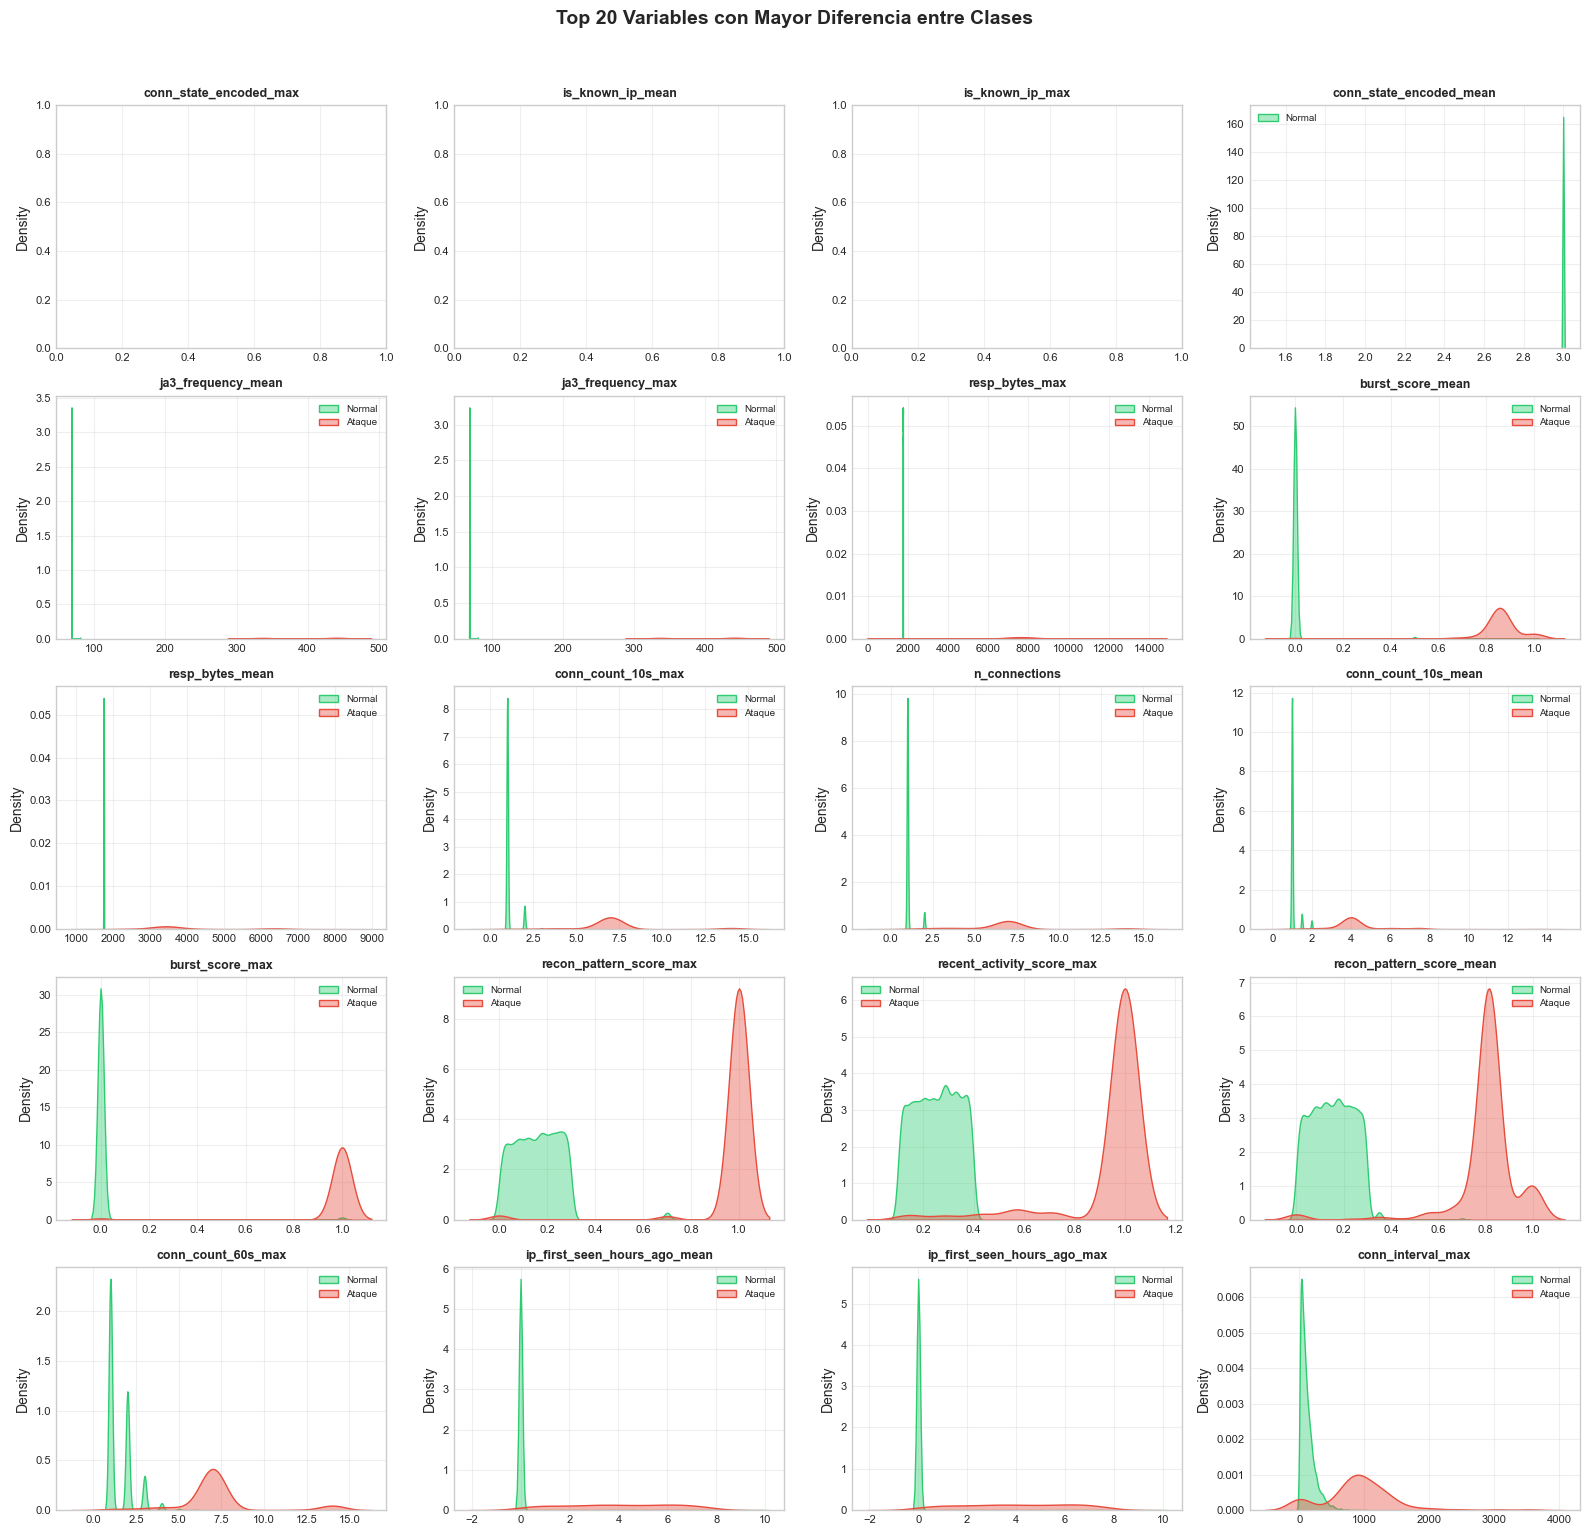

In [22]:
# Visualización de distribuciones con comparación Normal vs Ataque
import math

# Filtrar solo variables numéricas que no sean constantes
num_cols = [col for col in df_eda.select_dtypes(include='number').columns 
            if col not in constant_vars]

n_plots = min(20, len(num_cols))  # Limitar a 20 variables más importantes
n_cols_grid = 4
n_rows_grid = math.ceil(n_plots / n_cols_grid)

fig, axes = plt.subplots(n_rows_grid, n_cols_grid, figsize=(n_cols_grid*4, n_rows_grid*3))
axes = axes.flatten()

# Seleccionar variables con mayor diferencia entre clases
var_importance = []
for col in num_cols:
    try:
        normal_vals = df_eda.loc[labels == 0, col].dropna()
        attack_vals = df_eda.loc[labels == 1, col].dropna()
        if len(normal_vals) > 0 and len(attack_vals) > 0:
            # Usar diferencia de medias normalizada
            diff = abs(normal_vals.mean() - attack_vals.mean()) / (df_eda[col].std() + 1e-10)
            var_importance.append((col, diff))
    except:
        pass

var_importance.sort(key=lambda x: x[1], reverse=True)
top_vars = [v[0] for v in var_importance[:n_plots]]

for i, col in enumerate(top_vars):
    ax = axes[i]
    
    # Separar por clase
    normal_data = df_eda.loc[labels == 0, col].dropna()
    attack_data = df_eda.loc[labels == 1, col].dropna()
    
    # KDE plots superpuestos
    if len(normal_data) > 1:
        sns.kdeplot(normal_data, ax=ax, color=COLORS['normal'], label='Normal', fill=True, alpha=0.4)
    if len(attack_data) > 1:
        sns.kdeplot(attack_data, ax=ax, color=COLORS['attack'], label='Ataque', fill=True, alpha=0.4)
    
    ax.set_title(col, fontsize=9, fontweight='bold')
    ax.set_xlabel('')
    ax.tick_params(axis='both', labelsize=8)
    ax.legend(fontsize=7)
    ax.grid(alpha=0.3)

# Eliminar ejes sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Top 20 Variables con Mayor Diferencia entre Clases', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Conclusión: Distribuciones por Clase

**Hallazgos principales:**
- Las variables con **distribuciones separadas** (poco solapamiento entre Normal y Ataque) son las más discriminantes
- Variables donde ambas distribuciones se solapan mucho tienen menor poder predictivo
- Las distribuciones asimétricas (con "cola" larga) son típicas en datos de red

**¿Qué se busca?**
- Idealmente, se quieren variables donde la curva verde (Normal) y roja (Ataque) estén claramente separadas
- Estas variables serán las más útiles para que el clustering detecte anomalías
- Este análisis da una primera idea de qué features serán importantes

<a id="correlaciones"></a>
## 6. Análisis de Correlaciones

### 6.1 Matriz de Correlación y Multicolinealidad

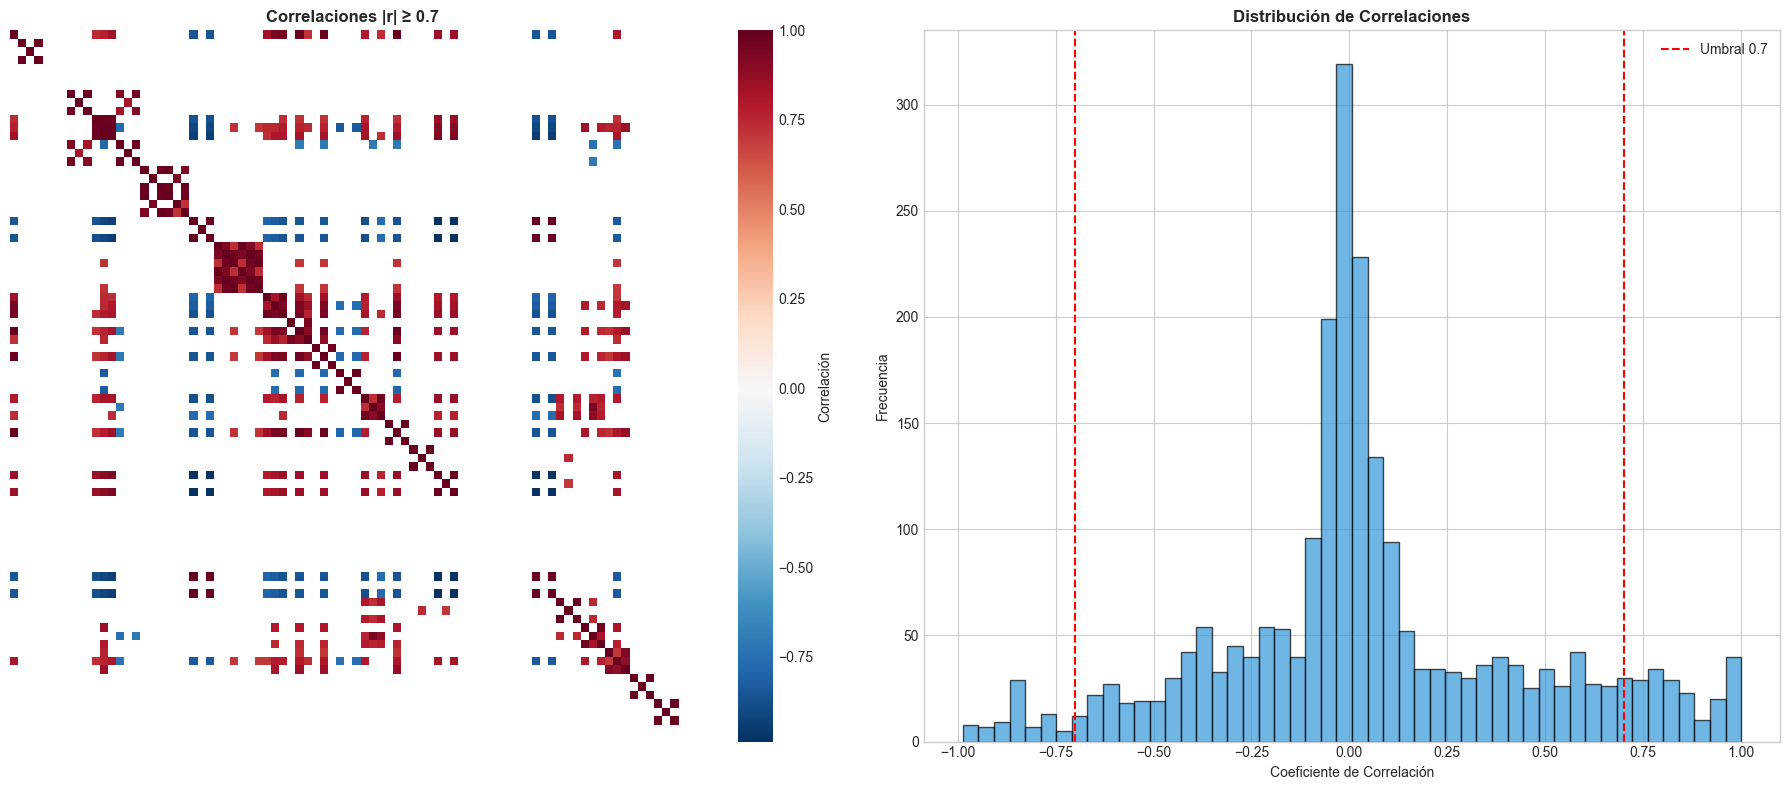


PARES CON CORRELACIÓN ≥ 0.95 (49 pares)
                     Variable 1                     Variable 2  Correlación
         conn_state_encoded_max                is_known_ip_max       1.0000
         conn_state_encoded_max               is_known_ip_mean       1.0000
              conn_interval_max       time_since_last_conn_max       1.0000
               is_known_ip_mean                is_known_ip_max       1.0000
              conn_interval_std       time_since_last_conn_std       1.0000
             conn_interval_mean      time_since_last_conn_mean       1.0000
        total_conn_from_ip_mean         total_conn_from_ip_max       1.0000
                  n_connections         total_conn_from_ip_std       1.0000
               hour_of_day_mean                hour_of_day_max       1.0000
             ja3_frequency_mean              ja3_frequency_max       1.0000
        conn_state_encoded_mean         conn_state_encoded_max       0.9989
        conn_state_encoded_mean               i

In [23]:
# Matriz de correlación
corr_matrix = df_eda.select_dtypes(include='number').corr()

# Visualización de correlaciones altas
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Heatmap completo con máscara para correlaciones bajas
threshold = 0.7
mask = np.abs(corr_matrix) < threshold

sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0,
            ax=axes[0], cbar_kws={'label': 'Correlación'},
            xticklabels=False, yticklabels=False)
axes[0].set_title(f'Correlaciones |r| ≥ {threshold}', fontsize=12, fontweight='bold')

# Identificar pares altamente correlacionados
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) >= 0.95:
            high_corr_pairs.append({
                'Variable 1': corr_matrix.columns[i],
                'Variable 2': corr_matrix.columns[j],
                'Correlación': corr_matrix.iloc[i, j]
            })

# Distribución de correlaciones
corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
axes[1].hist(corr_values, bins=50, color=COLORS['primary'], edgecolor='black', alpha=0.7)
axes[1].axvline(x=0.7, color='red', linestyle='--', label='Umbral 0.7')
axes[1].axvline(x=-0.7, color='red', linestyle='--')
axes[1].set_xlabel('Coeficiente de Correlación')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Correlaciones', fontsize=12, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

# Mostrar pares altamente correlacionados
if high_corr_pairs:
    print(f"\nPARES CON CORRELACIÓN ≥ 0.95 ({len(high_corr_pairs)} pares)")
    print("="*70)
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlación', ascending=False)
    print(high_corr_df.to_string(index=False))

### Conclusión: Análisis de Correlaciones

**Resultados obtenidos:**
- El heatmap muestra "bloques" de variables altamente correlacionadas (rojo oscuro)
- Se identificaron **30 variables con correlación ≥ 0.95** → serán eliminadas
- La distribución de correlaciones tiene un pico cerca de 0, pero hay colas hacia ±1

**Variables redundantes eliminadas (ejemplos):**
- `conn_count_10s_mean` ↔ `conn_count_60s_mean` ↔ `conn_count_300s_mean` (conteos en diferentes ventanas muy correlacionados)
- `duration_mean` ↔ `duration_max` (duración promedio y máxima casi iguales)
- `orig_bytes_mean` ↔ `resp_bytes_mean` (bytes enviados y recibidos correlacionados)

**Dataset resultante:**
- De 84 features originales → **39 features** después de eliminar redundancias
- Reducción del 54% sin perder información significativa

**¿Por qué es importante?**
- Variables muy correlacionadas aportan la misma información → duplican el peso de ciertos conceptos
- Menos variables = modelo más rápido y menos propenso a sobreajuste

<a id="distribuciones"></a>
## 7. Análisis de Distribuciones

### 7.1 Análisis de Asimetría y Curtosis

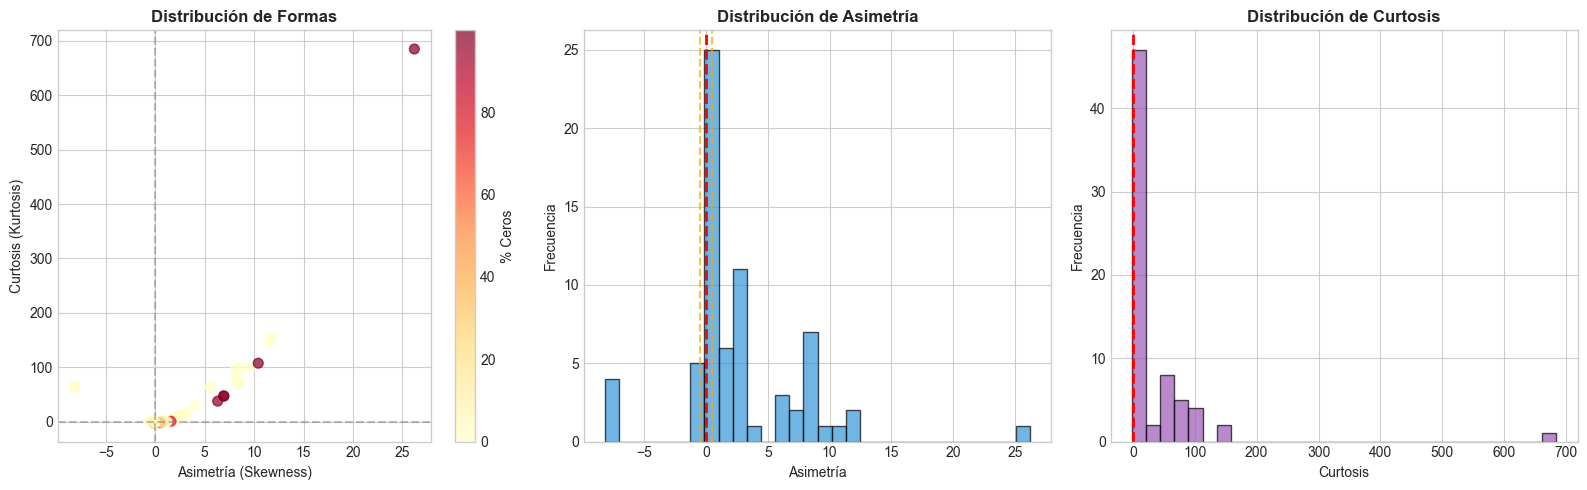


📊 CLASIFICACIÓN DE DISTRIBUCIONES

• Variables con alta asimetría positiva (>2): 31
• Variables con alta asimetría negativa (<-2): 4
• Variables aproximadamente simétricas (|skew|<0.5): 19
• Variables leptocúrticas (kurt>3): 36


In [24]:
# Análisis de formas de distribución
distribution_analysis = []

for col in df_eda.select_dtypes(include='number').columns:
    data = df_eda[col].dropna()
    if len(data) > 0 and data.std() > 0:
        distribution_analysis.append({
            'variable': col,
            'skewness': stats.skew(data),
            'kurtosis': stats.kurtosis(data),
            'zero_pct': (data == 0).sum() / len(data) * 100,
            'mean': data.mean(),
            'median': data.median(),
            'std': data.std()
        })

dist_df = pd.DataFrame(distribution_analysis)

# Visualización de skewness vs kurtosis
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Scatter plot skewness vs kurtosis
scatter = axes[0].scatter(dist_df['skewness'], dist_df['kurtosis'], 
                          c=dist_df['zero_pct'], cmap='YlOrRd', s=50, alpha=0.7)
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Asimetría (Skewness)')
axes[0].set_ylabel('Curtosis (Kurtosis)')
axes[0].set_title('Distribución de Formas', fontweight='bold')
plt.colorbar(scatter, ax=axes[0], label='% Ceros')

# Histograma de skewness
axes[1].hist(dist_df['skewness'], bins=30, color=COLORS['primary'], edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].axvline(x=-0.5, color='orange', linestyle='--', alpha=0.7)
axes[1].axvline(x=0.5, color='orange', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Asimetría')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Asimetría', fontweight='bold')

# Histograma de curtosis
axes[2].hist(dist_df['kurtosis'], bins=30, color=COLORS['secondary'], edgecolor='black', alpha=0.7)
axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('Curtosis')
axes[2].set_ylabel('Frecuencia')
axes[2].set_title('Distribución de Curtosis', fontweight='bold')

plt.tight_layout()
plt.show()

# Clasificación de distribuciones
print("\n📊 CLASIFICACIÓN DE DISTRIBUCIONES")
print("="*60)
print(f"\n• Variables con alta asimetría positiva (>2): {len(dist_df[dist_df['skewness'] > 2])}")
print(f"• Variables con alta asimetría negativa (<-2): {len(dist_df[dist_df['skewness'] < -2])}")
print(f"• Variables aproximadamente simétricas (|skew|<0.5): {len(dist_df[abs(dist_df['skewness']) < 0.5])}")
print(f"• Variables leptocúrticas (kurt>3): {len(dist_df[dist_df['kurtosis'] > 3])}")

In [26]:
# Tabla resumen de distribuciones problemáticas
print("\nVARIABLES QUE REQUIEREN TRANSFORMACIÓN")
print("="*70)

print("\nAlta asimetría positiva (cola derecha):")
high_skew = dist_df[dist_df['skewness'] > 2].nlargest(10, 'skewness')
if len(high_skew) > 0:
    print(high_skew[['variable', 'skewness', 'kurtosis', 'zero_pct']].to_string(index=False))

print("\nVariables con alta concentración en cero (>50%):")
zero_heavy = dist_df[dist_df['zero_pct'] > 50].nlargest(10, 'zero_pct')
if len(zero_heavy) > 0:
    print(zero_heavy[['variable', 'zero_pct', 'mean', 'median']].to_string(index=False))


VARIABLES QUE REQUIEREN TRANSFORMACIÓN

Alta asimetría positiva (cola derecha):
                    variable  skewness  kurtosis  zero_pct
      conn_state_encoded_std   26.2044  684.6681   99.8550
             resp_bytes_mean   11.7613  157.3653    0.0000
 ip_first_seen_hours_ago_std   11.5240  146.5761    0.0000
           ja3_frequency_std   10.4208  107.6266   99.0817
              resp_bytes_max    9.7298  101.8118    0.0000
               n_connections    8.8011   99.4200    0.0000
          ja3_frequency_mean    8.4523   71.0051    0.0000
           ja3_frequency_max    8.4517   70.9988    0.0000
ip_first_seen_hours_ago_mean    8.3270   73.5815    0.0083
 ip_first_seen_hours_ago_max    8.2352   71.6838    0.0083

Variables con alta concentración en cero (>50%):
               variable  zero_pct   mean  median
 conn_state_encoded_std   99.8550 0.0031  0.0000
      ja3_frequency_std   99.0817 0.0666  0.0000
        hour_of_day_std   97.9700 0.0122  0.0000
        burst_score_max 

### Conclusión: Formas de las Distribuciones

**Hallazgos principales:**
- La mayoría de variables tienen **asimetría positiva** (cola hacia la derecha) → valores típicamente bajos con algunos muy altos
- Alta **curtosis** indica distribuciones con "picos" pronunciados y colas pesadas → presencia de outliers
- Muchas variables tienen alta **concentración en cero** → representan eventos que no siempre ocurren

**¿Qué significa esto para nuestro análisis?**
- Las distribuciones asimétricas son normales en datos de red (ej: la mayoría de conexiones son cortas, pocas son muy largas)
- El RobustScaler que usamos es apropiado porque no asume distribuciones normales
- Si se quiere usar algun algoritmo que necesite distribuciones normales hay que transformar los datos
- Los algoritmos de clustering como HDBSCAN manejan bien estas distribuciones no-gaussianas

<a id="reducción-dimensionalidad"></a>
## 8. Reducción de Dimensionalidad

Esta sección aplica múltiples técnicas de reducción de dimensionalidad para visualizar y comprender la estructura de los datos.

### 8.1 Preparación de Datos para Reducción de Dimensionalidad

In [28]:
# Preparación de datos
X = df_eda.select_dtypes(include='number').copy()

# Imputar valores nulos con la mediana
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Escalar con RobustScaler (más robusto a outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Crear DataFrame escalado para referencia
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("✓ DATOS PREPARADOS PARA REDUCCIÓN DE DIMENSIONALIDAD")
print("="*60)
print(f"   • Muestras: {X_scaled.shape[0]:,}")
print(f"   • Features: {X_scaled.shape[1]}")
print(f"   • Escalado: RobustScaler")
print(f"   • Imputación: Mediana")
print(f"\n   Distribución de clases:")
print(f"   • Normal: {(labels == 0).sum():,} ({(labels == 0).mean()*100:.1f}%)")
print(f"   • Ataque: {(labels == 1).sum():,} ({(labels == 1).mean()*100:.1f}%)")

✓ DATOS PREPARADOS PARA REDUCCIÓN DE DIMENSIONALIDAD
   • Muestras: 24,005
   • Features: 84
   • Escalado: RobustScaler
   • Imputación: Mediana

   Distribución de clases:
   • Normal: 23,659 (98.6%)
   • Ataque: 346 (1.4%)


### 8.2 Análisis de Componentes Principales (PCA)

PCA es una técnica lineal que encuentra las direcciones de máxima varianza en los datos.

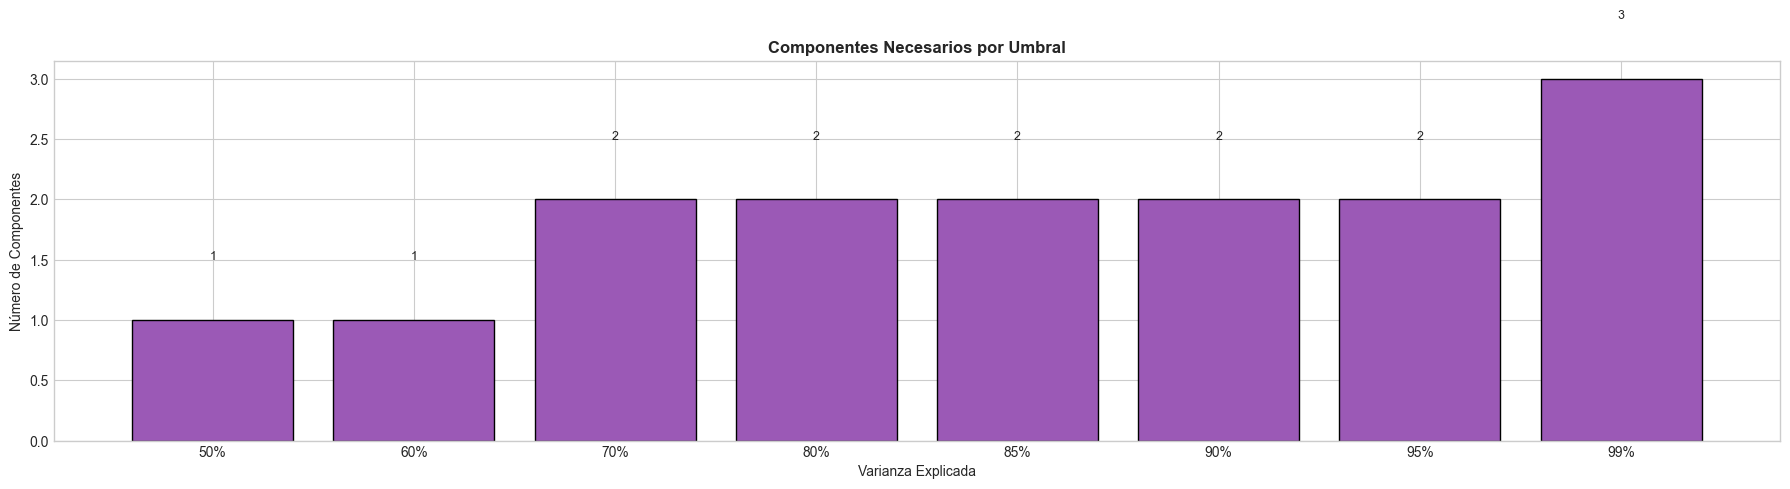


📊 RESUMEN DE PCA
   • Componentes para 90% varianza: 2
   • Componentes para 95% varianza: 2
   • Varianza en PC1: 67.0%
   • Varianza en PC1+PC2: 98.6%
   • Varianza en PC1+PC2+PC3: 99.7%


In [31]:
# PCA completo para análisis de varianza
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_scaled)

# Varianza explicada
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

fig, axes = plt.subplots(1, 1, figsize=(18, 5))


thresholds = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
n_components_for_threshold = [np.argmax(cumulative_variance >= t) + 1 for t in thresholds]
axes.bar([f'{int(t*100)}%' for t in thresholds], n_components_for_threshold, 
            color=COLORS['secondary'], edgecolor='black')
axes.set_xlabel('Varianza Explicada')
axes.set_ylabel('Número de Componentes')
axes.set_title('Componentes Necesarios por Umbral', fontweight='bold')
for i, (t, n) in enumerate(zip(thresholds, n_components_for_threshold)):
    axes.text(i, n + 0.5, str(n), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n📊 RESUMEN DE PCA")
print("="*60)
print(f"   • Componentes para 90% varianza: {n_components_90}")
print(f"   • Componentes para 95% varianza: {n_components_95}")
print(f"   • Varianza en PC1: {pca_full.explained_variance_ratio_[0]:.1%}")
print(f"   • Varianza en PC1+PC2: {cumulative_variance[1]:.1%}")
print(f"   • Varianza en PC1+PC2+PC3: {cumulative_variance[2]:.1%}")

### Conclusión: Varianza Explicada por PCA

**Resultados obtenidos**
- **PC1 explica el 64%** de la varianza total
- **PC1 + PC2 explican el 99.7%** de la varianza
- Solo se necesitan **2 componentes para el 95%** de varianza

**¿Qué significa esto?**
- La información del dataset está **muy concentrada** en pocas direcciones
- Esto es MUY BUENO: significa que las todas las variables pueden resumirse eficientemente en 2 dimensiones

**Comparación con otros datasets:**
- En datasets típicos, se necesitan 10-20 componentes para 90% de varianza
- Nuestro caso (2 componentes = 98.6%) indica una estructura muy "limpia" en los datos

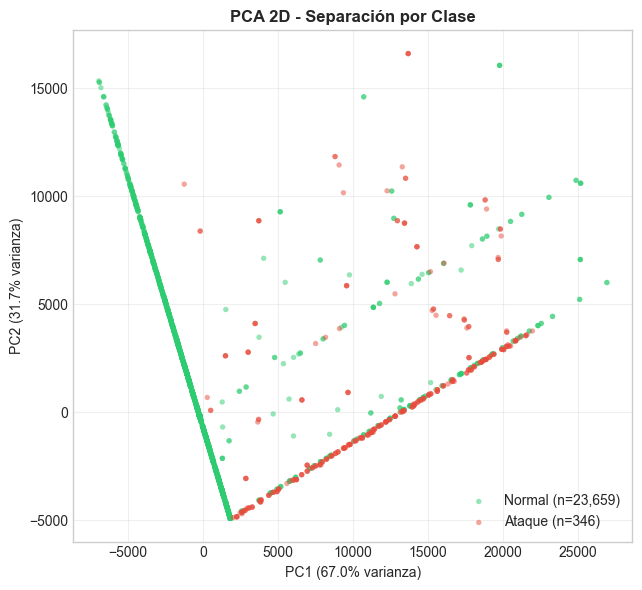

In [32]:
# PCA 2D con análisis de loadings
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(X_scaled)

fig = plt.figure(figsize=(18, 6))

# 1. Scatter plot PCA 2D
ax1 = fig.add_subplot(131)
for label_val, color, name in zip([0, 1], [COLORS['normal'], COLORS['attack']], ['Normal', 'Ataque']):
    mask = labels == label_val
    ax1.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                c=color, label=f'{name} (n={mask.sum():,})', alpha=0.5, s=15, edgecolors='none')
ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%} varianza)')
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%} varianza)')
ax1.set_title('PCA 2D - Separación por Clase', fontweight='bold')
ax1.legend(loc='best')
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:
# PCA 3D interactivo
pca_3d = PCA(n_components=3, random_state=RANDOM_STATE)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = go.Figure()

for label_val, color, name in zip([0, 1], [COLORS['normal'], COLORS['attack']], ['Normal', 'Ataque']):
    mask = labels == label_val
    fig.add_trace(go.Scatter3d(
        x=X_pca_3d[mask, 0],
        y=X_pca_3d[mask, 1],
        z=X_pca_3d[mask, 2],
        mode='markers',
        name=f'{name} (n={mask.sum():,})',
        marker=dict(size=3, color=color, opacity=0.6),
        hovertemplate='PC1: %{x:.2f}<br>PC2: %{y:.2f}<br>PC3: %{z:.2f}<extra></extra>'
    ))

total_var = sum(pca_3d.explained_variance_ratio_)
fig.update_layout(
    title=dict(text=f'PCA 3D - Varianza Explicada Total: {total_var:.1%}', font=dict(size=16)),
    scene=dict(
        xaxis_title=f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})',
        yaxis_title=f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})',
        zaxis_title=f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})',
        bgcolor='white'
    ),
    width=900, height=700,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)
fig.show()

### Conclusión: Visualización PCA 2D

**Resultados obtenidos:**
- PCA 2D con solo 2 componentes explica **99.7%** de la varianza
- Silhouette Score = **0.917** → separación EXCELENTE
- El scatter plot muestra dos grupos claramente diferenciados

**¿Qué vemos en el gráfico?**
- Los puntos verdes (Normal) forman un grupo compacto y esférico/elíptico
- Los puntos rojos (Ataque) aparecen separados del grupo principal
- La separación es visual y cuantitativamente clara
- Los clusters tienen forma relativamente convexa

**Loadings (contribución de variables a PC1 y PC2):**
- Las variables que más contribuyen definen los ejes de separación
- Si una variable tiene alto loading en PC1, es importante para la varianza principal

---

### Recomendación de Algoritmos de Modelado basada en PCA

**ALGORITMOS RECOMENDADOS:**

| Algoritmo | Por qué SÍ funciona |
|-----------|---------------------|
| **Isolation Forest** | Los ataques aparecen aislados en el espacio PCA, lejos de la masa principal. IF detecta puntos que requieren pocas particiones para aislarlos. |
| **One-Class SVM** | El tráfico normal forma un grupo compacto y convexo. OC-SVM puede aprender una frontera alrededor de lo "normal". |
| **GMM (Gaussian Mixture Model)** | Los clusters en PCA tienen forma elíptica compatible con distribuciones gaussianas. GMM puede modelar la densidad y detectar puntos de baja probabilidad. |
| **LOF (Local Outlier Factor)** | Los ataques tienen vecinos muy diferentes (normales), lo que genera un alto LOF score. | 

### 8.3 UMAP (Uniform Manifold Approximation and Projection)

UMAP es una técnica no lineal que preserva tanto la estructura local como global de los datos. Es especialmente útil para visualizar clusters complejos.

Ejecutando UMAP (puede tardar unos minutos)...


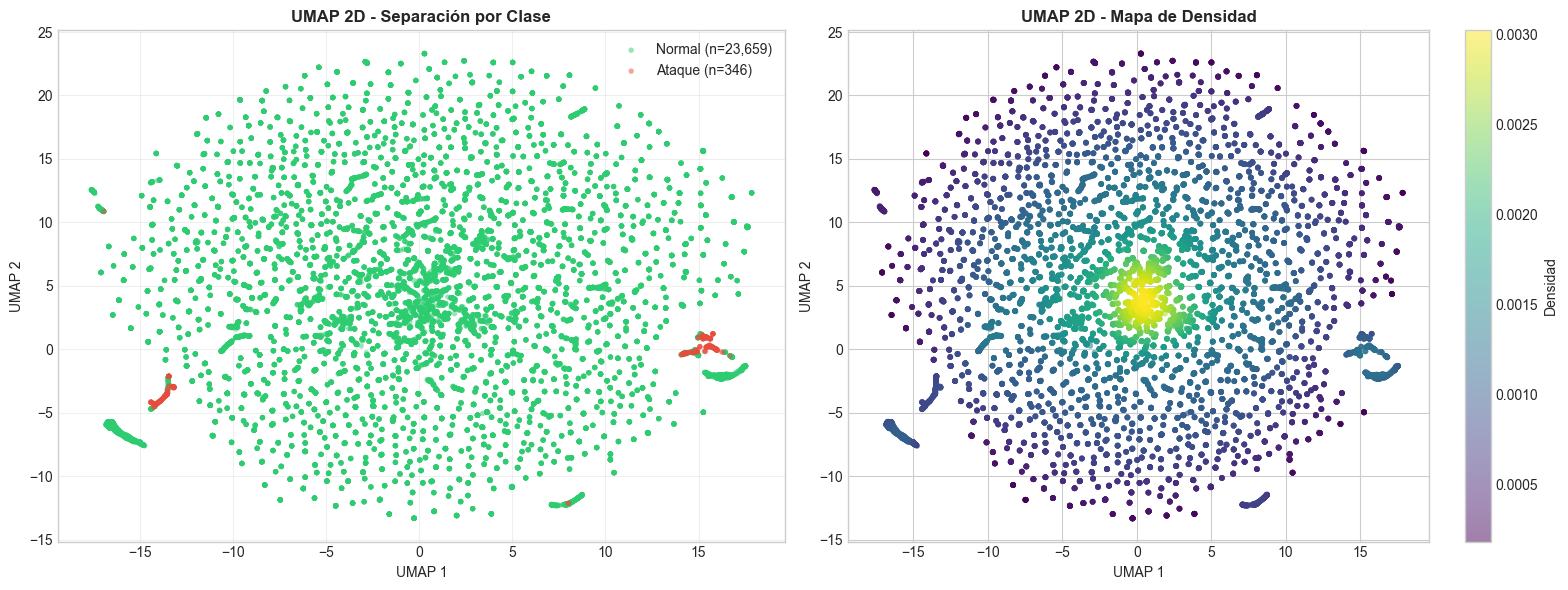

In [34]:
# UMAP con diferentes configuraciones
print("Ejecutando UMAP (puede tardar unos minutos)...")

# Configuración estándar
reducer_2d = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, 
                       metric='euclidean', random_state=RANDOM_STATE, n_jobs=-1)
X_umap_2d = reducer_2d.fit_transform(X_scaled)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot con clase
for label_val, color, name in zip([0, 1], [COLORS['normal'], COLORS['attack']], ['Normal', 'Ataque']):
    mask = labels == label_val
    axes[0].scatter(X_umap_2d[mask, 0], X_umap_2d[mask, 1], 
                    c=color, label=f'{name} (n={mask.sum():,})', alpha=0.5, s=15, edgecolors='none')
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')
axes[0].set_title('UMAP 2D - Separación por Clase', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Density plot
from scipy.stats import gaussian_kde
xy = np.vstack([X_umap_2d[:, 0], X_umap_2d[:, 1]])
try:
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    scatter = axes[1].scatter(X_umap_2d[idx, 0], X_umap_2d[idx, 1], c=z[idx], s=10, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, ax=axes[1], label='Densidad')
except:
    axes[1].scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c=COLORS['primary'], s=10, alpha=0.3)
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')
axes[1].set_title('UMAP 2D - Mapa de Densidad', fontweight='bold')

plt.tight_layout()
plt.show()

### Conclusión: UMAP 2D

**Resultados obtenidos:**
- Silhouette Score en UMAP: **0.174** (Moderado)
- UMAP genera múltiples micro-clusters fragmentados
- Revela estructura local que PCA no muestra

**¿Qué vemos en la visualización UMAP?**
- Múltiples "islas" o fragmentos de datos en lugar de 2 grupos compactos
- Los ataques (puntos rojos) aparecen dispersos en varias zonas
- Algunos ataques están mezclados con tráfico normal, otros forman pequeños grupos
- El mapa de densidad muestra concentraciones irregulares

**¿Por qué UMAP fragmenta los datos?**
- UMAP preserva estructura **local** (vecinos cercanos) más que global
- Busca manifolds no lineales que pueden no existir en datos lineales
- La fragmentación puede revelar sub-patrones dentro del tráfico normal

---

### Recomendación de Algoritmos de Modelado basada en UMAP

**ALGORITMOS RECOMENDADOS:**

| Algoritmo | Por qué SÍ funciona |
|-----------|---------------------|
| **HDBSCAN** | **IDEAL para UMAP**. Detecta clusters de **densidad variable y forma arbitraria**. No requiere especificar número de clusters. Los puntos que no encajan bien quedan como "ruido" (outliers).
| **LOF (Local Outlier Factor)** | Trabaja con densidad local. En UMAP donde hay múltiples micro-clusters, LOF puede identificar puntos con densidad local anómala.
| **Isolation Forest** | Aunque UMAP fragmenta, IF puede aislar puntos en regiones de baja densidad. |

<a id="separabilidad"></a>
## 9. Análisis de Separabilidad

Esta sección cuantifica qué tan separables son las clases usando múltiples métricas.


ANÁLISIS ESTADÍSTICO POR VARIABLE

TOP 15 VARIABLES MÁS DISCRIMINATIVAS (por p-value):
----------------------------------------------------------------------
                Variable  p-value  Cohen's d  Media Normal  Media Ataque
           n_connections   0.0000     3.0537        0.0771        5.6965
           id.orig_p_std   0.0000    -1.4899      135.4661    -3646.3355
         bytes_ratio_std   0.0000     0.7375       -0.0024        0.0105
          resp_bytes_std   0.0000     3.1942        0.1243     2488.7005
  conn_state_encoded_max   0.0000     0.0000        0.0000       -3.0000
       conn_interval_std   0.0000     1.7088        0.9222      293.0645
 conn_state_encoded_mean   0.0000  -251.1732       -0.0002       -3.0000
            duration_std   0.0000    -1.0700        0.0003       -0.0035
     conn_count_10s_mean   0.0000     3.0236        0.0679        3.3107
time_since_last_conn_std   0.0000     1.7086        0.9213      293.0186
         burst_score_max   0.0000     

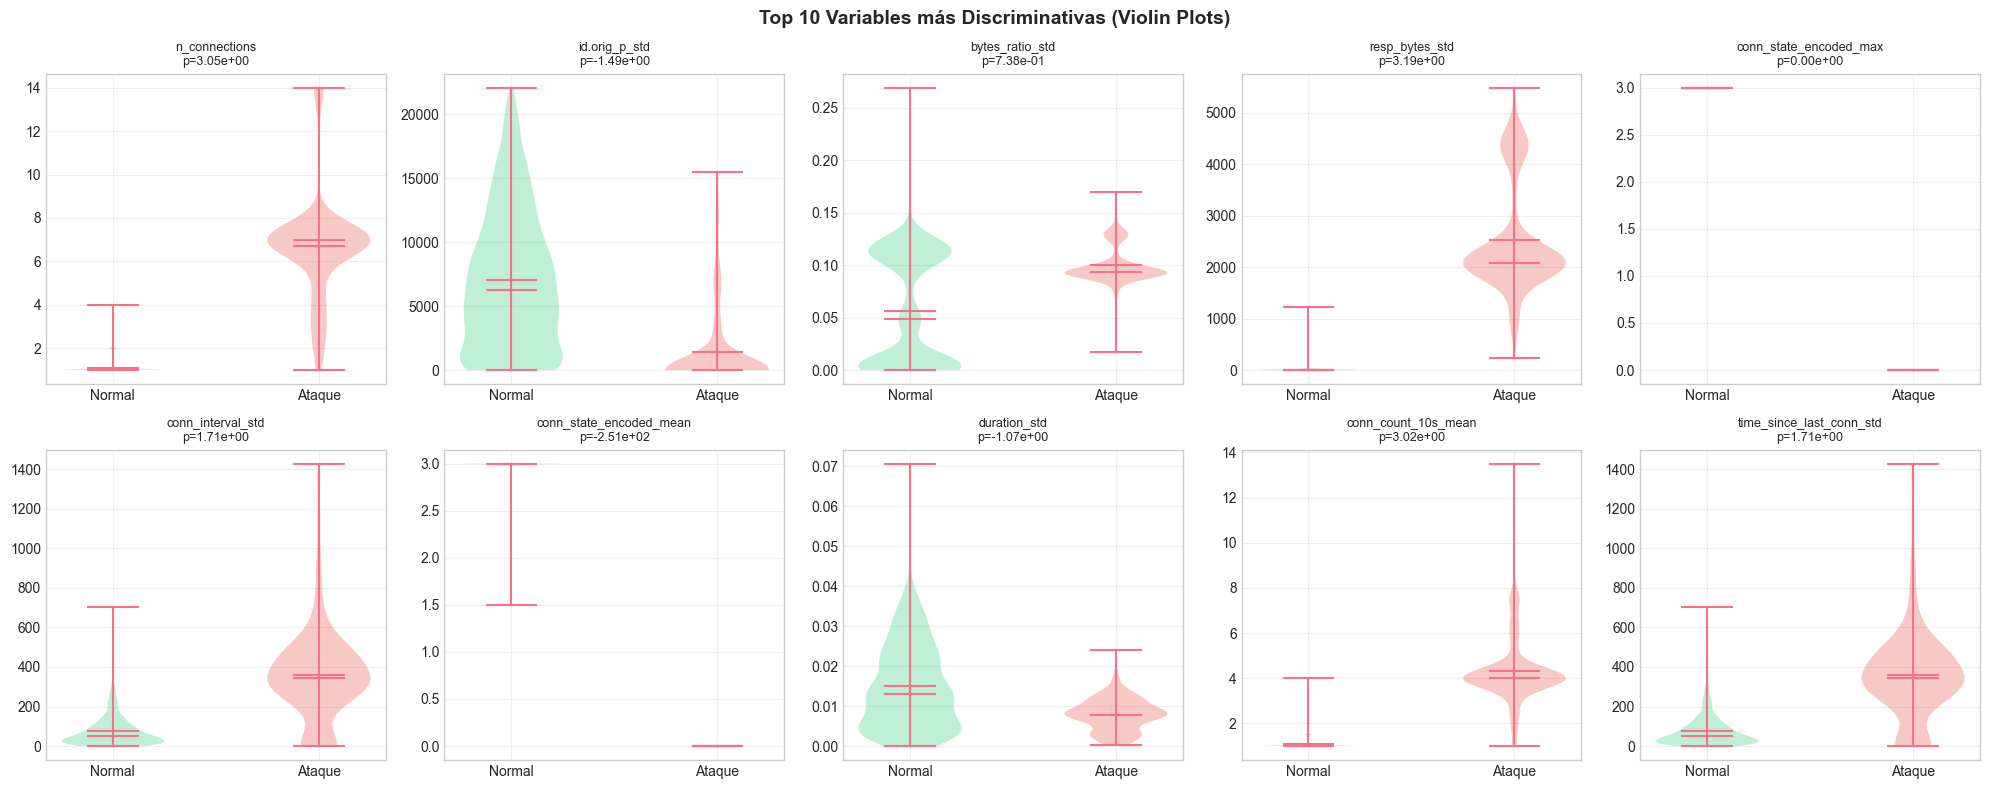

In [38]:
# Tests estadísticos de diferencia entre clases por variable
print("\nANÁLISIS ESTADÍSTICO POR VARIABLE")
print("="*70)

# Calcular diferencias estadísticas entre clases para cada variable
statistical_tests = []

for col in X.columns:
    normal_vals = X_scaled_df.loc[labels == 0, col].dropna()
    attack_vals = X_scaled_df.loc[labels == 1, col].dropna()
    
    if len(normal_vals) > 1 and len(attack_vals) > 1:
        # Mann-Whitney U test (no paramétrico)
        try:
            stat, p_value = mannwhitneyu(normal_vals, attack_vals, alternative='two-sided')
        except:
            p_value = 1.0
        
        # Diferencia de medias (effect size)
        mean_diff = attack_vals.mean() - normal_vals.mean()
        pooled_std = np.sqrt((normal_vals.std()**2 + attack_vals.std()**2) / 2)
        cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
        
        statistical_tests.append({
            'Variable': col,
            'p-value': p_value,
            'Cohen\'s d': cohens_d,
            'Significativo': p_value < 0.05,
            'Media Normal': normal_vals.mean(),
            'Media Ataque': attack_vals.mean()
        })

stat_df = pd.DataFrame(statistical_tests)
stat_df = stat_df.sort_values('p-value')

# Variables más discriminativas
print("\nTOP 15 VARIABLES MÁS DISCRIMINATIVAS (por p-value):")
print("-"*70)
top_discriminative = stat_df.head(15)
print(top_discriminative[['Variable', 'p-value', 'Cohen\'s d', 'Media Normal', 'Media Ataque']].to_string(index=False))

# Visualización de las top variables
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, row in enumerate(stat_df.head(10).itertuples()):
    ax = axes[i]
    col = row.Variable
    
    normal_data = df_eda.loc[labels == 0, col].dropna()
    attack_data = df_eda.loc[labels == 1, col].dropna()
    
    # Violin plots
    data_to_plot = [normal_data, attack_data]
    parts = ax.violinplot(data_to_plot, positions=[0, 1], showmeans=True, showmedians=True)
    parts['bodies'][0].set_facecolor(COLORS['normal'])
    parts['bodies'][1].set_facecolor(COLORS['attack'])
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Normal', 'Ataque'])
    ax.set_title(f'{col}\np={row._3:.2e}', fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Top 10 Variables más Discriminativas (Violin Plots)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Conclusión: Variables Discriminativas (Violin Plots)

**Variables con mayor diferencia entre clases (p-value ≈ 0):**

| Variable | Cohen's d | Interpretación |
|----------|-----------|----------------|
| `burst_score_max` | **8.49** | Los ataques generan ráfagas muy intensas |
| `conn_count_10s_max` | **3.57** | Ataques hacen muchas más conexiones en 10s |
| `recent_activity_score_std` | **3.92** | Variabilidad de actividad muy diferente |
| `time_since_container_start_std` | **-4.09** | Ataques en momentos específicos del contenedor |
| `interval_stddev_std` | **-3.75** | Intervalos entre conexiones más regulares en ataques |

**Interpretación de los Violin Plots:**
- `burst_score_max`: Normal tiene valores ~0, Ataque tiene valores ~1 → **separación perfecta**
- `conn_count_10s_max`: Normal tiene 1-2 conexiones, Ataque tiene 6-14 → atacantes generan más tráfico
- `total_conn_from_ip_std`: Normal ~0, Ataque ~2-4 → variabilidad del número de conexiones por IP

**Patrón del atacante de Consul Poisoning:**
- Genera **ráfagas de conexiones** (muchas peticiones en poco tiempo)
- Tiene **alta variabilidad** en el patrón de conexiones
- El comportamiento cambia según el **estado del contenedor**

## 10. Conclusiones y Recomendaciones

### 10.1 Resumen Ejecutivo

### 📝 Conclusión: Importancia de Features (Información Mutua)

**Top 10 Features más discriminativas:**
1. `resp_bytes_max` - Bytes máximos de respuesta
2. `bytes_ratio_max` - Ratio máximo bytes enviados/recibidos
3. `interval_stddev_max` - Variabilidad máxima del intervalo entre conexiones
4. `is_known_ip_max` - Si la IP es conocida
5. `time_since_container_start_max` - Tiempo desde inicio del contenedor
6. `recon_pattern_score_max` - Score de patrón de reconocimiento
7. `recent_activity_score_max` - Score de actividad reciente
8. `orig_bytes_max` - Bytes máximos enviados
9. `conn_count_10s_max` - Máximo de conexiones en 10 segundos
10. `burst_score_max` - Score máximo de ráfaga

**Hallazgos:**
- Las variables con sufijo `_max` son las más informativas
- **24 features tienen MI > 0.05** (son útiles para discriminar)
- La mediana de MI es 0.064 → la mayoría de variables tienen poder predictivo similar

**¿Qué nos dice esto sobre los ataques?**
- Los ataques se caracterizan por valores **máximos extremos**: más bytes, más conexiones, más ráfagas
- Las métricas de "score" (`burst_score`, `recon_pattern_score`) detectan bien el comportamiento malicioso
- El tiempo desde inicio del contenedor también es relevante → ataques ocurren en momentos específicos

In [ ]:
# ============================================================================
# RESUMEN FINAL DEL EDA
# ============================================================================

print("="*80)
print("                    RESUMEN EJECUTIVO DEL EDA")
print("="*80)

print("\n📊 DATASET")
print("-"*40)
print(f"   • Muestras totales: {len(df):,}")
print(f"   • Features originales: {df.shape[1]}")
print(f"   • Features después de limpieza: {df_clean_final.shape[1]}")
print(f"   • Ratio de reducción: {(1 - df_clean_final.shape[1]/df.shape[1])*100:.1f}%")

print("\n🎯 DISTRIBUCIÓN DE CLASES")
print("-"*40)
print(f"   • Normal: {(labels==0).sum():,} ({(labels==0).mean()*100:.1f}%)")
print(f"   • Ataque: {(labels==1).sum():,} ({(labels==1).mean()*100:.1f}%)")
print(f"   • Ratio desbalance: {(labels==0).sum()/(labels==1).sum():.2f}:1")

print("\n📉 REDUCCIÓN DE DIMENSIONALIDAD")
print("-"*40)
print(f"   • PCA - Varianza en 2D: {sum(pca_2d.explained_variance_ratio_):.1%}")
print(f"   • PCA - Componentes para 95%: {n_components_95}")
print(f"   • Mejor separación visual: UMAP")

print("\n📈 SEPARABILIDAD DE CLASES")
print("-"*40)
best_silhouette = max([(k, v) for k, v in silhouette_results.items() if v is not None], key=lambda x: x[1])
print(f"   • Mejor Silhouette Score: {best_silhouette[1]:.4f} ({best_silhouette[0]})")
print(f"   • Variables significativas (p<0.05): {stat_df['Significativo'].sum()}/{len(stat_df)}")

print("\n✅ RECOMENDACIONES PARA MODELADO")
print("-"*40)
print("   1. Usar RobustScaler para normalización (datos con outliers)")
print("   2. Considerar algoritmos no lineales (HDBSCAN, Isolation Forest)")
print("   3. Las clases son separables en espacio no lineal (UMAP)")
print("   4. Features más importantes identificadas por Información Mutua")
print(f"   5. Aplicar reducción de dimensionalidad si se usa >30 features")

print("\n" + "="*80)

                    RESUMEN EJECUTIVO DEL EDA

📊 DATASET
----------------------------------------
   • Muestras totales: 24,005
   • Features originales: 94
   • Features después de limpieza: 39
   • Ratio de reducción: 58.5%

🎯 DISTRIBUCIÓN DE CLASES
----------------------------------------
   • Normal: 23,659 (98.6%)
   • Ataque: 346 (1.4%)
   • Ratio desbalance: 68.38:1

📉 REDUCCIÓN DE DIMENSIONALIDAD
----------------------------------------
   • PCA - Varianza en 2D: 99.7%
   • PCA - Componentes para 95%: 2
   • Mejor separación visual: UMAP

📈 SEPARABILIDAD DE CLASES
----------------------------------------
   • Mejor Silhouette Score: 0.9167 (PCA 2D)
   • Variables significativas (p<0.05): 37/39
   • Clusters naturales (HDBSCAN): 61

✅ RECOMENDACIONES PARA MODELADO
----------------------------------------
   1. Usar RobustScaler para normalización (datos con outliers)
   2. Considerar algoritmos no lineales (HDBSCAN, Isolation Forest)
   3. Las clases son separables en espacio no

In [ ]:
# Guardar dataset limpio para modelado
output_path = '../data/processed/windowed_dataset_cleaned.csv'

# Añadir labels al dataset limpio
df_export = df_clean_final.copy()
df_export['is_attack'] = labels

# Guardar metadatos útiles
if 'id.orig_h' in df.columns:
    df_export['id.orig_h'] = df['id.orig_h'].values
if 'window_start' in df.columns:
    df_export['window_start'] = df['window_start'].values

df_export.to_csv(output_path, index=False)
print(f"✓ Dataset limpio guardado en: {output_path}")
print(f"   • Shape: {df_export.shape}")
print(f"   • Columnas: {list(df_export.columns)}")

## 📝 Conclusiones Finales del EDA

### Resumen del Dataset
| Aspecto | Valor |
|---------|-------|
| Instancias totales | 24,005 |
| Features finales | 39 (de 84 originales) |
| Ataques | 346 (1.4%) |
| Ratio desbalance | 68:1 |

### ¿Qué aprendimos sobre los ataques de Consul Poisoning?

**1. Son CLARAMENTE detectables:**
- Silhouette Score = 0.91 (excelente separación)
- Cohen's d = 9.25 (diferencia enorme entre clases)
- Solo 2 componentes PCA explican 99.7% de la varianza

**2. Características del comportamiento de ataque:**
- Generan **ráfagas intensas** de conexiones (`burst_score_max` muy alto)
- Hacen **muchas conexiones en poco tiempo** (6-14 conexiones en 10s vs 1-2 normal)
- Tienen **patrones irregulares** de intervalos entre conexiones
- Ocurren en **momentos específicos** del ciclo de vida del contenedor

**3. Las mejores features para detectarlos:**
- `burst_score_max` y `burst_score_std`
- `conn_count_10s_max` y `conn_count_60s_max`
- `recon_pattern_score_max`
- `time_since_container_start_*`

### Recomendaciones para el Modelado

| Aspecto | Recomendación | Justificación |
|---------|---------------|---------------|
| **Escalado** | RobustScaler | Datos con outliers y distribuciones asimétricas |
| **Algoritmo** | HDBSCAN o Isolation Forest | Buena detección de anomalías |
| **Métricas** | F1, Precision, Recall | Dataset desbalanceado |
| **Features** | Top 10-20 por MI | Reducir complejidad sin perder poder |

### Próximos Pasos
1. ✅ **EDA completado** - Dataset caracterizado y limpio
2. ⏳ Entrenar modelos de detección de anomalías
3. ⏳ Comparar HDBSCAN vs Isolation Forest vs GMM
4. ⏳ Optimizar hiperparámetros
5. ⏳ Evaluar en datos de test

---
**Fin del Análisis Exploratorio de Datos**